## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand

from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance
from scipy.stats import entropy

## Load Data - MOCAP

In [2]:
# loading entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/trajectories/'
trajectories = os.listdir(path)

## Data Cleansing

In [3]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i, time_bin in enumerate(trajectories):
    trajectory = loadmat(path + time_bin)
    trajectory = trajectory['trajectory'] 
    for i in range(trajectory.shape[1]):
        if np.isnan(trajectory[:, i]).all():
            nan_cols.append(i)

sampling_factor = 15
nan_cols = np.asarray(nan_cols)
if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
    sampled_trajectories = np.zeros(((trajectory.shape[0]*int(len(trajectories)/sampling_factor)), trajectory.shape[1]-3))
    all_trajectories = np.zeros((trajectory.shape[0]*int(len(trajectories)), trajectory.shape[1]-3))
    a = 0
    for i, time_bin in enumerate(trajectories):
        trajectory = loadmat(path + time_bin)
        trajectory = trajectory['trajectory'] 
        trajectory = np.delete(trajectory, nan_cols, 1)
        idx = a*trajectory.shape[0]
        idx_2 = i*trajectory.shape[0]
        all_trajectories[idx_2:idx_2+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
        if i % sampling_factor == 0 and sampled_trajectories.shape[0]-idx >= trajectory.shape[0]:
            sampled_trajectories[idx:idx+trajectory.shape[0], 0:sampled_trajectories.shape[1]] = trajectory
            a+=1
        
print(sampled_trajectories.shape)
print(all_trajectories.shape)

(540000, 57)
(8100000, 57)


## Load Data - BEHAVIOURS

In [4]:
# load behavioural time series and corresponding marker location time series
idxs_behaviours = loadmat('/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/traj_1_idx_behaviours.mat')
frames_6Hz = loadmat('/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/traj_1_norm_analysis.mat')
idxs_behaviours = idxs_behaviours['behaviours']
frames_6Hz = frames_6Hz['multi_D_traj_norm_6Hz']

## Data Cleansing

In [5]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i in range(frames_6Hz.shape[1]):
    if np.isnan(frames_6Hz[:, i]).all():
        nan_cols.append(i)

frames_6Hz = np.delete(frames_6Hz, nan_cols, 1)
print(frames_6Hz.shape)

(51569, 57)


## Dimensionality Reduction: PCA

0.6022192248292773


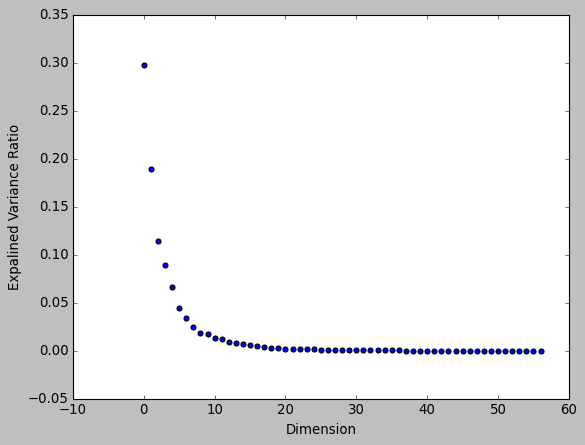

In [6]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(all_trajectories)

plt.scatter(np.arange(all_trajectories.shape[1]), pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[0:3]))
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj_300 = pca.fit_transform(all_trajectories)
reduced_traj_6 = pca.fit_transform(frames_6Hz)

## Entropy Analysis

### Helper functions

In [9]:
def mov_average(data, window_length, shift_length):
    av_data = []
    a = 0
    for i in range(0,len(data),shift_length):
        if i>=window_length:
            av_data.append(np.mean(data[i-window_length:i]))
            a = a + 1
    return av_data

In [10]:
def prob_vector(raw_data, max_size, min_, decimals=1):
    rounded_data = [(round(x * 10**(decimals)))/(10**decimals) for x in raw_data]
    sorted_data = np.sort(rounded_data)
    sorted_data = np.array(sorted_data, dtype=np.float64)

    already_seen = []
    prob_vector = np.zeros((max_size+1))
    occurrences = 0
    idx = 0
    for datapoint in sorted_data:
        if datapoint not in already_seen:
            occurrences = np.count_nonzero(sorted_data == datapoint)
            already_seen.append(datapoint)
            idx = int((datapoint - min_)/(1/10**decimals))
            prob_vector[idx] = (occurrences/len(sorted_data))
    
    return prob_vector

In [11]:
def get_mPE_matrix(reduced_traj, bins_number, traj_number, orders=[3]):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx = 0
            idx_1 = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = i*bins_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                if traj.shape[0]>0:
                    [HH, _]=mPE(traj, order)
                    mPE_vector[i, idx , a] = HH
                idx += 1
                
    return mPE_vector

In [12]:
def get_vel_matrix(trajectory, bins_number=30, traj_number=30, least_varaince_zdim=8*3):
    f_s = 300
    vel_matrix = np.zeros((bins_number, traj_number))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for i in range(bins_number):
        idx = 0
        idx_1 = 0
        for j in range(0, traj_length*traj_number, traj_length):
            idx_1 = i*bins_number*traj_length 
            traj = trajectory[idx_1 + j: idx_1 + j + traj_length, least_varaince_zdim:least_varaince_zdim+3]
            vel_bin = 0
            last_point = traj[0, :]
            for point in traj:
                vel_bin = vel_bin + distance.euclidean(point, last_point)
                last_point = point
            vel_matrix[i, idx] = vel_bin
            idx += 1
                
    return vel_matrix

In [13]:
def behavioural_entropy(behav_time_series, bins_number, traj_number, mode):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx = 0
            idx_1 = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = i*bins_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                if mode=='PE':
                    [HH,hh_norm]=mPE(traj, order)
                elif mode=='Shannon':
                    HH = entropy(traj, base=2)
                mPE_vector[i, idx , a] = HH
                idx += 1
                
    return mPE_vector

In [7]:
def joint_prob_matrix(x, y, n_behaviours, truncation_decimal=1):
    # Checking that the dimensions are in the right order
    if x.shape[0] < x.shape[1]:
        x = np.transpose(x)
    if y.shape[0] < y.shape[1]:
        y = np.transpose(y)
        
    # reducing position array to 2D to avoid spoarse probability matrix
    x = x[:, 0:2]
    # rounding reduced trajectory to 2 decimal place
    rounded_x = np.zeros((x.shape[0], x.shape[1]))
    for i, row in enumerate(x):
        rounded_x[i, :] = [(round(j * 10**(truncation_decimal)))/(10**truncation_decimal) for j in row]    
        rounded_x = np.asarray(rounded_x)
    # finding max and min of reduced trajectory data
    min_ = float('inf')
    max_ = float('-inf')
    for time_point in range(rounded_x.shape[0]):
        for positions in range(rounded_x.shape[1]):
            if rounded_x[time_point, positions] > max_:
                max_ = rounded_x[time_point, positions]
            elif rounded_x[time_point, positions] < min_:
                min_ = rounded_x[time_point, positions]

    min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
    max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
    # finding the maximimum number of elements in the rounded position matri
    max_size = int((max_ - min_)/(1/(10**truncation_decimal)))
    # concatating joint data (x and y) --> (each row of joint data consits of [PC1, PC2, behaviour index])
    joint_data = np.concatenate((rounded_x, y), axis=1)
    print(joint_data.shape)
    
    # filling joint probability matrix
    already_seen = []
    joint_prob_matrix = 2*np.ones((max_size, n_behaviours))
    occurrences, idx_location, idx_behaviour = 0, 0, 0
    for joint_array in joint_data:
        if joint_array not in already_seen:
            occurrences = np.count_nonzero(joint_data == joint_array)
            already_seen.append(joint_array)
            print(already_seen)
            found = False
            while found == False:
                idx_location = np.random.randint(max_size)
                if joint_prob_matrix[idx_location, idx_behaviour] == 2:
                    found = True
                    break
            idx_behaviour = int(joint_array[joint_data.shape[1]-1])
            print(idx_location, idx_behaviour)
            joint_prob_matrix[idx_location, idx_behaviour] = (occurrences/joint_data.shape[0])
    
    return joint_prob_matrix

In [8]:
print(frames_6Hz[0:5, :])
joint_prob = joint_prob_matrix(reduced_traj_6, idxs_behaviours, 1831)

[[ 0.63390071  0.57122535  3.10892011  0.15475589  0.20640495  3.3184168
  -0.70651723  0.28543659  3.44997771 -0.95382846  0.10276487  3.65862678
   2.30161773  0.29298204 -1.41660046  0.08085668 -0.13146117  2.44040458
   2.25224637 -0.2485683  -1.60767644  2.13408934  0.269718   -0.98404378
   1.63541359  0.15017642 -1.20954804 -0.48889219 -0.35156809 -1.60132942
  -0.62722613  0.67950465 -0.81444749  1.67538727  0.72774281 -1.22861511
  -0.17806401  0.25789891 -0.49358814 -1.06949366  0.53645487 -0.24706764
  -0.77117576  0.71179953 -0.01522117 -2.1339038   3.883402    0.93464969
   0.94792273  3.22138972  2.55514556  0.19242606  3.02730384  2.24588366
  -2.37236937 -0.12466681  1.69084643]
 [ 1.88544013 -0.7232113   1.28517588  1.35122408 -0.69382296  1.56716706
   1.77307933 -0.57952324  1.80428693  1.52040424 -1.33307587  2.32758904
   2.1524284  -0.28969625 -1.52634756  0.87237981  0.26682984  2.00232903
   1.4301921  -0.43185468 -1.81097374  1.72914047 -0.18561304 -1.20237615


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Entropy time-evolution

In [ ]:
# Entropy Calculation:
# - Divide entire trajetcory in 'bins_number' bins
# - Divide each bin for 'traj_number' trajectories
# - Calculate mPE for each of these trajectories 
minutes = 6
f_s = 300
bin_length = f_s*60*minutes
bins_number = int(reduced_traj.shape[0]/bin_length)
traj_number = 30
orders = [3]

print(reduced_traj.shape[0], bins_number, traj_number)

mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders)

9039600 83 30


In [ ]:
# entropy distribution visualization

# plotting mpE of the first bin 
mode = 'hist'
bin_n = 2
order_n = 0
fig = plt.figure()

# plotting histograms of two different bins
if mode == 'hist':
    n, bins, patches = plt.hist(x = mPE_vector[bin_n, :, order_n] , bins='auto', color='green',
                                alpha=0.7, rwidth=0.85)
    n, bins, patches = plt.hist(x= mPE_vector[mPE_vector.shape[0]-5, :, order_n] , bins='auto', color='red',
                                alpha=0.7, rwidth=0.85)

# plotting mPE continuous distribution as a function of time 
elif mode =='distribution':
    print(bins_number)
    bins = np.arange(bins_number)
    means = np.zeros(((bins_number),1))
    for bin_n in range(bins_number):
        means[bin_n] = np.mean(mPE_vector[bin_n, :, order_n])
        # ax = sns.displot(mPE_vector[bin_n, :, order_n],  kind="kde")        
        ax = sns.distplot(mPE_vector[bin_n, :, order_n], hist=False, kde=True, 
                          bins=0.1, 
                          hist_kws={'edgecolor':'black'},
                          kde_kws={'linewidth': 4})
        
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mPE')
plt.ylabel('Probability')

print((means))
fig = plt.figure()
plt.plot(np.arange(bins_number), means)
plt.xlabel('time bin')
plt.ylabel('mean mPE')

In [ ]:
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[traj, bin_, order] > max_:
                max_ = mPE_vector[traj, bin_, order]
            elif mPE_vector[traj, bin_, order] < min_:
                min_ = mPE_vector[traj, bin_, order]

truncation_decimal = 1
min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

# plotting J-S divergence as a function of bin number
compare_to = prob_vector(mPE_vector[0, :, 0], max_size, min_)
js_vector = np.zeros((mPE_vector.shape[0]))
ks_vector = np.zeros((mPE_vector.shape[0], 2))
ks_and_div = np.zeros((mPE_vector.shape[0], 2))
significance_lev = 0.01
for i in range(mPE_vector.shape[0]):
    js_vector[i] = distance.jensenshannon(prob_vector(mPE_vector[i, :, 0], max_size, min_), compare_to)
    ks_and_div[i, 0] = js_vector[i]
    if i > 0:
        ks_vector[i, :] = stats.ks_2samp(mPE_vector[i, :, 0], mPE_vector[0, :, 0])
        if ks_vector[i, 1] <= significance_lev:
            ks_and_div[i, 1] = 1
        else:
            ks_and_div[i, 1] = 0
            
fig = plt.figure()
# plotting velocity profile of mouse (point-wise)
plt.plot(np.arange(mPE_vector.shape[0]), js_vector)
plt.xlabel('bin number')
plt.ylabel('J-S Divergence')

js_rejected = np.where(ks_and_div[:,1] == 1)
js_th = float('inf')
for i in js_rejected[0]:
    if ks_and_div[i, 0] < js_th:
        js_th = ks_and_div[i, 0]
    
fig = plt.figure()
plt.scatter(ks_and_div[:, 0], ks_and_div[:, 1])
plt.axhline(y=significance_lev, xmin=0, xmax=1)
plt.axvline(x=js_th, ymin=0, ymax=1.2)
plt.xlabel('J-S Divergence')
plt.ylabel('P-Value')

## Entropy Behavioral Analysis

In [ ]:
# Entropy Calculation:
# - Divide entire trajetcory in 'bins_number' bins
# - Divide each bin for 'traj_number' trajectories
# - Calculate mPE for each of these trajectories 
minutes = 15
f_s = 6
bin_length = f_s*60*minutes
bins_number = int(frames_6Hz_red.shape[0]/bin_length)
traj_number = 1
orders = [3]
mPE_vector = get_mPE_matrix(frames_6Hz_red, bins_number, traj_number, orders)

print(frames_6Hz_red.shape[0], bins_number, traj_number)